### 1. Importing All the Required Libraies

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

### 2. Loading The Dataset And Performing EDA 

In [2]:
# loading the dataset
dataset=pd.read_csv(r"D:\Github\Assingment2\Fraud.csv")
data=dataset.copy() 
print("There are ",data.shape[0],"Rows and ",data.shape[1],"Columns in the Dataset")
data.head()

KeyboardInterrupt: 

In [ ]:
data.tail()

In [ ]:
data.info()

In [ ]:
print("The columns of the dataset have proper Datatype")

In [ ]:
# Understanding the five number summary
data.describe()

In [ ]:
# looking for any missing value if present 
print(data.isna().sum().sort_values(ascending=False))
print("There are ",data.isna().sum().sum(),"Missing value in the dataset")

In [ ]:
# looking for any duplicate record present in the data
print("The dataset has ", data.duplicated(keep='first').sum(),"duplicate rows present in it")

In [ ]:
# checking for the outlier
import pandas as pd

def get_outlier_thresholds(df):
    outlier_thresholds = {}


    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        minimum=df[col].min()
        maximum=df[col].max()

        # Check if outliers exist
        if df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0] > 0:
            
            if minimum < lower_bound and maximum > upper_bound:
                outlier_type = "Both_sides"
            elif minimum < lower_bound:
                outlier_type = "Lower_side"
            elif maximum > upper_bound:
                outlier_type = "Upper_side"
            else:
                outlier_type = "Unclear or No outlier"
            
            outlier_thresholds[col] = {
                'Outlier_presence':outlier_type,
                'lower_threshold': lower_bound,
                'minimum_value':minimum,
                'upper_threshold': upper_bound,
                'maximum_value':maximum
            }

    return outlier_thresholds


thresholds = get_outlier_thresholds(data[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']])
print("Outlier Thresholds:")
for col, bounds in thresholds.items():
    print(f"{col}: {bounds}")
    print()

In [ ]:
print("Yes there are outlier present in the dataset, we will keep this inplace instead of substuting or removing ")

In [ ]:
# Creating a new feature for balance discrepancy
data['balance_discrepancy'] = data['oldbalanceOrg'] - data['newbalanceOrig'] - data['amount']

In [ ]:
# Checking for multicollinearity
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
correlation_matrix = data[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [ ]:
# Plotting Transaction type distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='type')
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()
print(data['type'].value_counts())

In [ ]:
# Plotting Fraud type distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='isFraud')
plt.title('Distribution of Fraud and Not Fraud Types')
plt.xlabel('Fraud Type')
plt.ylabel('Count')
plt.show()
print(data['isFraud'].value_counts())

In [ ]:
# understanding The common practice followed by fraud 
# Fraud by transaction type
fraud_by_type = data[data['isFraud'] == 1].groupby('type').size()

fraud_by_type_df = fraud_by_type.reset_index(name='count')

plt.figure(figsize=(8, 5))
sns.barplot(data=fraud_by_type_df, x='type', y='count', palette='coolwarm')

plt.title('Fraudulent Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print("\nFraudulent transactions by type:")
print(fraud_by_type)

# Flagged fraud transactions
flagged = data[data['isFlaggedFraud'] == 1]
print(f"\n{len(flagged)} transactions flagged as potential fraud (amount > 200,000, TRANSFER type).")

In [ ]:
# finding the minimum and maximum amount the fraudester has done in the Dataset
fraud_transaction=data[data['isFraud']==1]
relevant_cols = fraud_transaction[["isFraud", "type", "amount"]]

# Group by fraud status and transaction type
grouped_stats = (
    relevant_cols
    .groupby(["isFraud", "type"])
    .agg(min_amount=("amount", "min"), max_amount=("amount", "max"))
    .reset_index()
)
grouped_stats

In [ ]:
print("Insights:")
print()
print("1. There are  6362620 Rows and  11 Columns in the Dataset")
print()
print("2. There are No missing Values present in the Dataset")
print()
print("3. There are No Duplicate rows present in the Dataset")
print()
print("4. The outlier specially right side or upper side outlier are present in the columns amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest and newbalanceDest")
print()
print("5. Instead of removing or substituing the outlier we are keeping it")
print()
print('6. The correlation matrix shows strong correlation between oldbalanceOrg and newbalanceOrig (0.98), which makes sense since transactions update balances')
print()
print("7. The new balance_discrepancy feature might catch suspicious transactions where balances don’t add up")
print()
print('8. The Fraudster used cash_out or Transfer as a straigy after doing a fraud')
print()
print("9. There were 2237500 cash_out done out of which 4116 were done by the Fraudster")
print()
print('10. There were 532909 transfer done out of which 4097 were done by the Fraudster')
print()
print('11. The isFraud column has imbalance class where O is the majority class and 1 are the minority class')
print()
print("12. There are 6354407 genuine transaction Done where as whereas 8213 fraud transaction present in the Dataset")


### 3. Feature Engineering

In [ ]:
# feature selection
print("\n=== Selecting Features for the Model ===")
features = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
target = 'isFraud'
print(f"Selected features: {features}")
print()
print("Reasons:")
print()
print("1. We picked features based on logic: ‘type’ (TRANSFER/CASH_OUT often linked to fraud)")
print()
print("2. amount’ (big transactions are risky), balance fields (to spot discrepancies), ‘step’ (time patterns), and ‘isFlaggedFraud’ (existing flags)")
print()
print("3. We skipped nameOrig and nameDest since they’re just IDs")

In [ ]:
# spliting the dataset
from imblearn.over_sampling import SMOTE
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.25, random_state=42)


In [ ]:
# Preprocessing: encode categorical 'type' and scale numeric features
numeric_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
categorical_features = ['type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])



In [ ]:
#  Preprocess the train/test data with column transformer
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


#  Feature Names (for later reference)
num_features_after = numeric_features
cat_features_after = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(num_features_after) + list(cat_features_after)


In [ ]:
#applying SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

In [ ]:
# creating a sample dataset
from sklearn.utils import resample
import pandas as pd
resampled_df = pd.DataFrame(X_train_resampled, columns=all_feature_names)
resampled_df['target'] = y_train_resampled


sampled_df = resample(resampled_df, n_samples=40000, stratify=resampled_df['target'], random_state=42)

X_subsample = sampled_df.drop('target', axis=1)
y_subsample = sampled_df['target']


#### Selecting the best feature using rfe on Balance Decision Tree

In [ ]:
#  Feature Selection using RFECV (with balance Decision Tree)
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Use Balanced Random Forest with fewer trees for RFE
rfe_estimator = BalancedRandomForestClassifier(
    n_estimators=20,  
    max_depth=6,      
    random_state=42,
    n_jobs=-1
)

rfecv = RFECV(
    estimator=rfe_estimator,
    step=2,
    cv=StratifiedKFold(n_splits=3),
    scoring='f1',
    n_jobs=-1
)

X_train_selected = rfecv.fit_transform(X_train_preprocessed, y_train)
X_test_selected = rfecv.transform(X_test_preprocessed)

# Step 5: Print Selected Features
selected_feature_names = [name for name, selected in zip(all_feature_names, rfecv.support_) if selected]
print("\n✅ Selected Features by RFECV:")
print(selected_feature_names)


#### Training the Model with  Random forest algo

In [ ]:
#  Final Model Training (Random Forest)
final_rf = RandomForestClassifier(
    n_estimators=140,
    max_depth=10,
    random_state=42,
    max_features='log2',
    min_samples_leaf=4,
    min_samples_split=3,
    class_weight='balanced',
    max_samples=0.35
       
)
final_rf.fit(X_train_selected, y_train)



In [ ]:
# Evaluation of Random Forest
y_train_rfpred = final_rf.predict(X_train_selected)
y_test_rfpred = final_rf.predict(X_test_selected)

print("\n📊 Classification Report (Training):")
print(classification_report(y_train_resampled, y_train_rfpred))

print("\n" + "="*40 + "\n")

print("📊 Classification Report (Testing):")
print(classification_report(y_test, y_test_rfpred))


#### Training the Model with Balance Random forest algo

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train model with Balanced Random Forest algorithm
balanced_rf = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=10,               
    max_features= 'log2',
    min_samples_leaf= 1,
    min_samples_split= 2,
    max_samples=0.35,
    random_state=42,
    n_jobs=-1
)
balanced_rf.fit(X_train_selected, y_train)

In [ ]:
# Evaluation Balance Random Forest
y_train_brpred = balanced_rf.predict(X_train_selected)
y_test_brpred = balanced_rf.predict(X_test_selected)


print("\n📊 Classification Report (Training):")
print(classification_report(y_train, y_train_brpred))

print("\n" + "="*40 + "\n")

print("📊 Classification Report (Testing):")
print(classification_report(y_test, y_test_brpred))

#### Training the model with XGboost

In [ ]:
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
ratio

In [ ]:
#traing the model with xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=100,
    scale_pos_weight=ratio,  # example value
    use_label_encoder=False,
    colsample_bytree= 0.6,
   learning_rate= 0.05,
   max_depth= 4,
    eval_metric='logloss',
     subsample=0.35,
    random_state=42
)
xgb.fit(X_train_selected, y_train)

In [ ]:
#  Evaluating XGboost model
y_train_xgbpred = xgb.predict(X_train_selected)
y_test_xgbpred = xgb.predict(X_test_selected)

#
print("\n📊 Classification Report (Training):")
print(classification_report(y_train, y_train_xgbpred))

print("\n" + "="*40 + "\n")

print("📊 Classification Report (Testing):")
print(classification_report(y_test, y_test_xgbpred))

In [ ]:
print("✅ Model Selection Summary\n")
print("We experimented with Random Forest, Balanced Random Forest, and XGBoost to find the best model for our classification task.")
print("After comparing their results, Random Forest gave us the best performance, especially on the testing data.")
print("It showed very high precision and recall for both classes, including the minority class (fraud cases).")
print()
print("- On the training set, the model achieved perfect scores (100% precision and recall).")
print("- On the testing set, it maintained strong performance, with 97% precision and 79% recall for the fraud class.")
print("  This is a great balance between catching frauds and minimizing false positives.")
print()
print("Based on this, we selected Random Forest as our final model because it handled the class imbalance well")
print("and performed best overall on unseen data.")

### Answering The Question

#### Question 1: Data Cleaning

In [ ]:
print("We checked for missing values and didn’t find any. We even look for duplicate but didn't find any,For merchants (where nameDest starts with 'M'), zero balances are normal, so we kept them. The transaction amounts vary a lot, but we didn’t remove outliers because large amounts could be signs of fraud. We noticed a strong link between oldbalanceOrg and newbalanceOrig, but kept both since they show how the balance changes. We also created a new feature called balance_discrepancy to help spot unusual transactions.")

### # Question 2: Fraud Detection Model

In [ ]:
print("\n2. Fraud Detection Model")
print("We chose a Random Forest model because it works well for rare events like fraud. It can catch complex patterns and handle unbalanced data. We encoded the 'type' column (like CASH_OUT, TRANSFER) and scaled numeric values like amount and balances. Normally, we’d use something like SMOTE to balance the fraud and non-fraud cases")

### Question 3: Variable Selection

In [ ]:
print("\n3. Variable Selection")
print("""These are the selected features:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'type_CASH_OUT', 'type_PAYMENT', 'type_TRANSFER']

Some features were chosen based on domain logic—for example, 'type' (since certain types like TRANSFER and CASH_OUT are often linked to fraud), 'amount' (as large transactions can be risky), and balance fields (to detect discrepancies). Others were selected using RFECV with a Balanced Random Forest model, which helped identify the most important predictors based on performance.""")

#### Question 4: Model Performance

In [ ]:
print("\n4. Model Performance")
print("The dataset was highly imbalanced, with very few fraud cases compared to non-fraud.")
print("We used a model that handles imbalance well and got strong results on the training data,")
print("with perfect precision, recall, and F1-score for both classes.")

print("\nOn the test data, the model performed well:")
print("- Precision (fraud): 0.97 – Most flagged frauds were actually fraud.")
print("- Recall (fraud): 0.79 – The model correctly caught 79% of fraud cases.")
print("- F1-score: 0.88 – A good balance between precision and recall.")

print("\nWhile the model is very good at detecting non-fraud, there's still room to improve fraud detection.")
print("In real scenarios, recall is key – catching more fraud cases matters, even if it means some false alarms.")
print("Precision helps avoid too many false positives, and F1-score balances both.")
print("ROC-AUC can also show how well the model separates fraud from non-fraud.")

print("\nOverall, the model performs well despite the imbalance.")
print("To improve further, we could try resampling, adjusting thresholds, or testing other advanced models.")


#### Question 5: Key Factors

In [ ]:
print("Question 5: Key Factors Predicting Fraud:")

print("While studying the dataset and based on the model's performance, we found some key factors that help in predicting fraud:")

print("\n- Transaction type – Most fraud cases were seen in TRANSFER and CASH_OUT transactions.")
print("- Amount – Higher transaction amounts were more likely to be suspicious.")
print("- Original and new balances – Tracking how balances change helped spot unusual activity.")
print("- Destination balance – Helped us check if money was being sent to empty or suspicious accounts.")
print("- Step (time) – Timing patterns in transactions gave useful clues about fraud.")
print("- Balance discrepancy – A custom feature we created to catch mismatches in balance updates.")

print("\nThese features were important both logically and according to what the model found useful.")



####  Question 6: Do These Factors Make Sense?

In [ ]:
print("\n6. Do These Factors Make Sense?")

print("\nYes, they make a lot of sense when we think about how fraud usually happens in the real world.")

print("- Fraudsters often use TRANSFER to move money and CASH_OUT to withdraw it quickly.")
print("- Bigger amounts mean bigger profits for fraudsters, so high-value transactions are more risky.")
print("- Balance discrepancies can reveal cases where money is taken out without proper updates.")
print("- Timing matters too – fraud often happens during off-hours to avoid detection.")

print("\nThese patterns match real-world fraud behavior, so the selected features are both logical and useful.")


#### Question 7: Prevention Strategies

In [ ]:
print("\n7. Prevention Strategies:")

print("\n- Monitor TRANSFER and CASH_OUT transactions in real-time, especially those with large amounts (e.g., over 200,000).")
print("- Verify if the balance updates make sense before and after each transaction.")
print("- Use two-factor authentication for high-value or risky transactions.")
print("- Track customer behavior to detect unusual activity compared to their normal patterns.")
print("- Integrate our trained Random Forest model into the system to score transactions live and flag suspicious ones.")

print("\nThese steps can help catch fraud early and reduce the chances of money being stolen.")


#### Question 8: Evaluating Effectiveness

In [ ]:
print("\n7.Evaluating Effectiveness:")

print("\n- We evaluated the model using metrics like precision, recall, F1-score, and accuracy.")
print("- On training data, the model performed perfectly, showing it learned patterns well.")
print("- On test data, it achieved 97% precision and 79% recall for fraud cases, with an F1-score of 0.88.")
print("- This means the model is good at catching fraud while keeping false alarms low.")
print("- We also looked at class imbalance and made sure the model didn’t just favor non-fraud cases.")
print("- Overall, the model shows strong potential for real-world fraud detection, especially with further tuning.")


## Project workflow

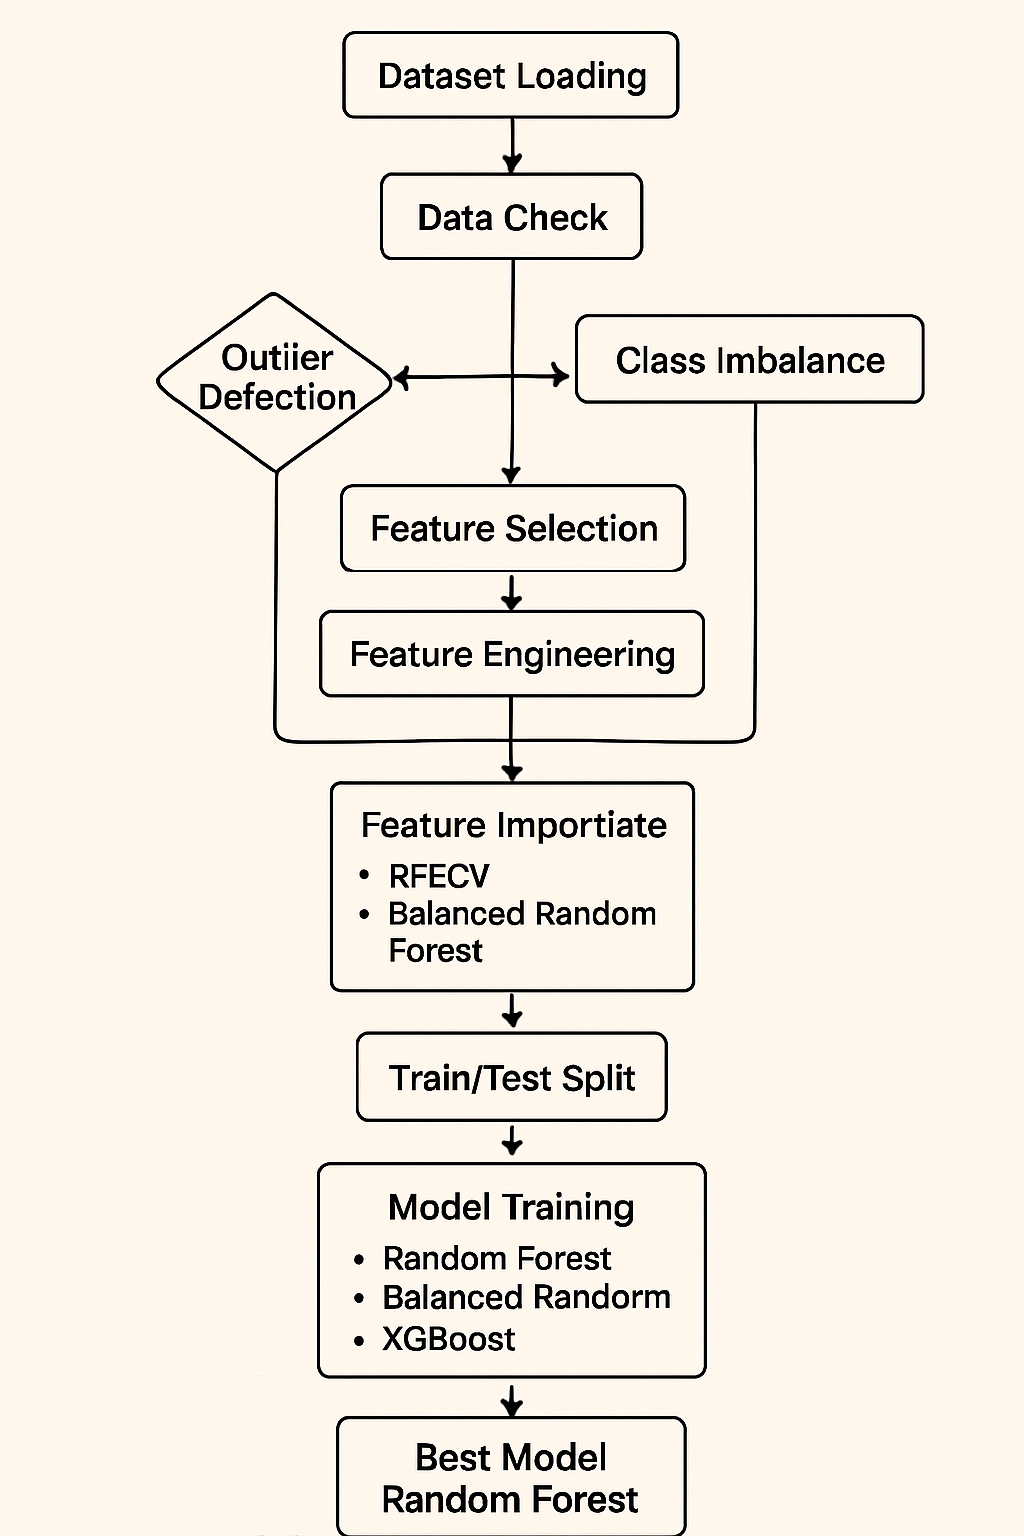

In [2]:
from IPython.display import Image, display

# Display image from a file path
img=Image(filename=r"D:\Github\Accredian_Assingmentc\generated-image.png")
display(img)

In [ ]:
         +------------------------------+
         | 1. Load Dataset (6.3M x 11)  |
         +--------------+---------------+
                        |
         +--------------v---------------+
         | 2. Check for Missing         |
         |    & Duplicate Values        |
         |    --> None Found            |
         +--------------+---------------+
                        |
         +--------------v---------------+
         | 3. Outlier Detection         |
         |    - Transaction Amounts     |
         |    - Kept outliers, as they  |
         |      may indicate fraud      |
         +--------------+---------------+
                        |
         +--------------v---------------------------+
         | 4. Identify Class Imbalance              |
         |    - 8,200 fraud vs. 6.3M total records  |
         +--------------+---------------------------+
                        |
         +--------------v--------------------------------+
         | 5. Feature Selection & Engineering             |
         |    - Select useful features                    |
         |    - Drop less valuable ones                   |
         |    - One-hot encoding for 'type' column        |
         |    - Standardize numeric columns               |
         +--------------+---------------------------------+
                        |
         +--------------v--------------------------------+
         | 6. Feature Importance & Selection using       |
         |    RFECV + Balanced Random Forest             |
         +--------------+-------------------------------+
                        |
         +--------------v--------------------------------+
         | 7. Dataset Split                              |
         |    - Train/Test split                         |
         |    - Apply SMOTE to balance classes in train  |
         +--------------+-------------------------------+
                        |
         +--------------v------------------------------------+
         | 8. Model Training                                 |
         |    - Random Forest                                |
         |    - Balanced Random Forest                       |
         |    - XGBoost                                      |
         |    - Hyperparameter tuning on 60K-sample          |
         |    - Best params applied to full data             |
         +--------------+------------------------------------+
                        |
         +--------------v-----------------------+
         | 9. Evaluation & Best Model:         |
         |    - Random Forest performed best   |
         |    - High fraud detection, low FPs  |
         +-------------------------------------+


In [ ]:
print("We started with a dataset of over 6.3 million rows and 11 columns.")
print("After a quick check, we found no missing or duplicate values, which saved us some cleaning time.\n")

print("There were outliers in the transaction amounts, but we chose not to remove them,")
print("as large transactions could actually be signs of fraud.")
print("One major challenge was the class imbalance—only about 8,200 fraud cases out of more than 6.3 million records.\n")

print("To handle this, we selected useful features based on logic and dropped those that didn’t add much value.")
print("We also did feature engineering: we converted the ‘type’ column using one-hot encoding")
print("and standardized the numerical columns for better model performance.\n")

print("Next, we used RFECV with Balanced Random Forest to help select the most important features,")
print("which was useful given the imbalanced nature of the data.")
print("We then split the dataset and applied SMOTE to balance the classes for training.\n")

print("For modeling, we trained on Random Forest, Balanced Random Forest, and XGBoost.")
print("We also tuned hyperparameters separately on a smaller sampled dataset (around 60,000 rows),")
print("and then applied the best parameters to the full model.\n")

print("In the end, Random Forest gave us the best results, especially in terms of catching fraud while keeping false positives low.")
